In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")


In [3]:
train = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/train.csv')
test = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/test.csv')
sample = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/sample_submission.csv')


In [4]:
train.dtypes 


id                    int64
customer_id           int64
last_name            object
credit_score        float64
country              object
gender               object
age                 float64
tenure                int64
acc_balance         float64
prod_count          float64
has_card            float64
is_active           float64
estimated_salary    float64
exit_status           int64
dtype: object

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                90000 non-null  int64  
 1   customer_id       90000 non-null  int64  
 2   last_name         90000 non-null  object 
 3   credit_score      80444 non-null  float64
 4   country           83979 non-null  object 
 5   gender            90000 non-null  object 
 6   age               90000 non-null  float64
 7   tenure            90000 non-null  int64  
 8   acc_balance       82743 non-null  float64
 9   prod_count        85137 non-null  float64
 10  has_card          90000 non-null  float64
 11  is_active         90000 non-null  float64
 12  estimated_salary  90000 non-null  float64
 13  exit_status       90000 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 9.6+ MB


In [6]:
train.describe()



,id,customer_id,credit_score,age,tenure,acc_balance,prod_count,has_card,is_active,estimated_salary,exit_status
count,90000.000000,9.000000e+04,80444.000000,90000.000000,90000.000000,82743.000000,85137.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,44999.500000,1.569209e+07,656.497054,38.119533,5.017022,55456.732147,1.552932,0.754289,0.497178,112394.659679,0.211600
std,25980.906451,7.129796e+04,80.016856,8.855203,2.804813,62788.474236,0.548011,0.430510,0.499995,50360.440702,0.408445
min,0.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,22499.750000,1.563361e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74430.360000,0.000000
50%,44999.500000,1.569016e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117505.070000,0.000000
75%,67499.250000,1.575674e+07,710.000000,42.000000,7.000000,119825.750000,2.000000,1.000000,1.000000,154874.787500,0.000000
max,89999.000000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
train.describe(include='object')  # For categorical

,last_name,country,gender
count,90000,83979,90000
unique,2611,3,2
top,Hsia,France,Male
freq,1343,47966,50914


In [8]:
train.isnull().sum()
test.isnull().sum()


id                     0
customer_id            0
last_name              0
credit_score        3185
country             4606
gender                 0
age                    0
tenure                 0
acc_balance         5251
prod_count          1717
has_card               0
is_active              0
estimated_salary       0
dtype: int64

In [9]:
imputer = SimpleImputer(strategy='median')
train['credit_score'] = imputer.fit_transform(train[['credit_score']])


In [10]:
train.duplicated().sum()
train = train.drop_duplicates()

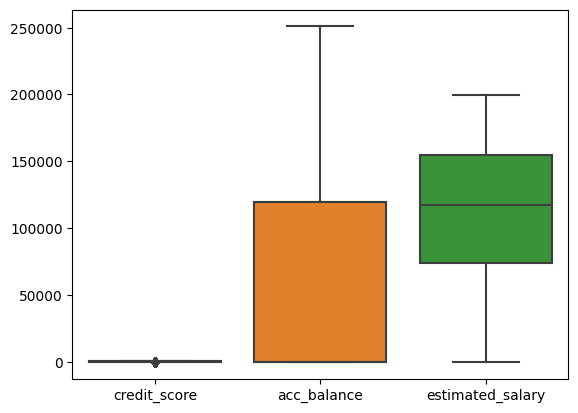

In [11]:
# Define numeric columns (skip target for now)
numeric_cols = ['credit_score', 'age', 'tenure', 'acc_balance', 'estimated_salary']
sns.boxplot(data=train[['credit_score', 'acc_balance', 'estimated_salary']])

def remove_and_cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Option 1: Remove rows with outliers (uncomment if needed)
        # df = df[(df[col] >= lower) & (df[col] <= upper)]

        # Option 2: Cap the outliers
        df[col] = np.where(df[col] > upper, upper,
                  np.where(df[col] < lower, lower, df[col]))
    return df

# Apply to train only (not test to avoid data leakage)
train = remove_and_cap_outliers(train, numeric_cols)


In [12]:
# Drop non-informative or ID-like columns
cols_to_drop = ['id', 'customer_id', 'last_name']
train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, inplace=True)


<Axes: >

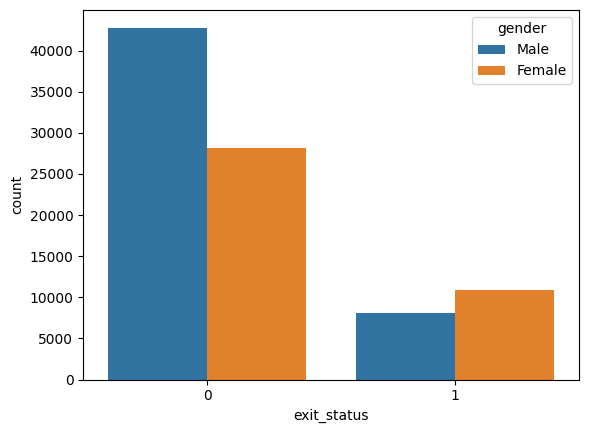

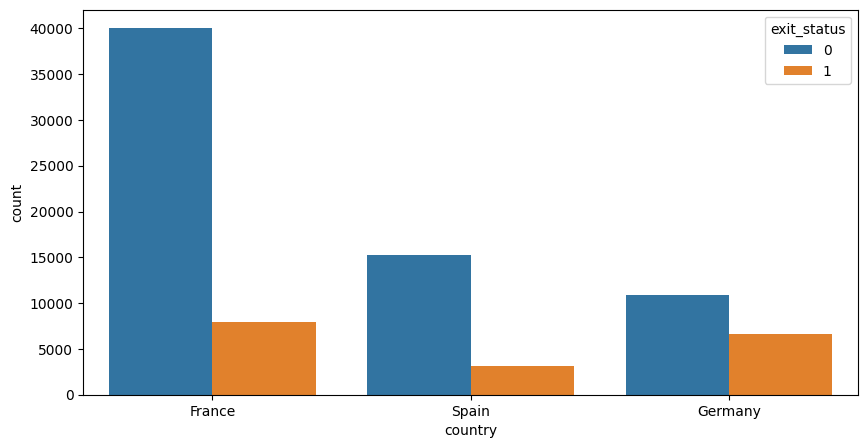

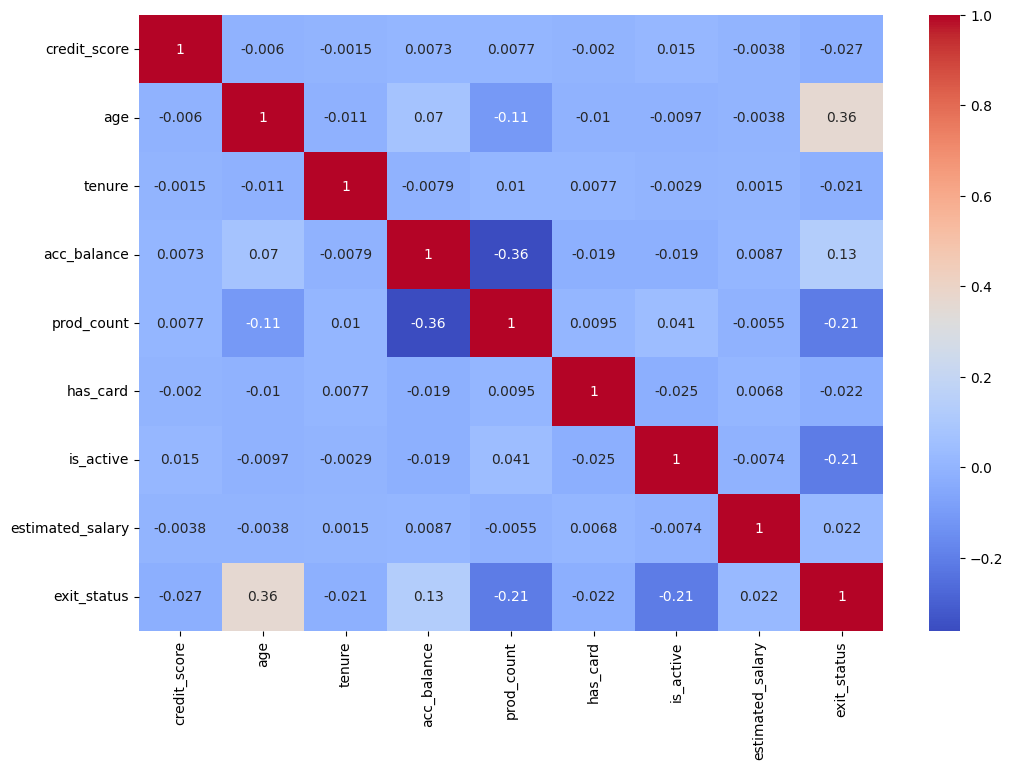

In [13]:
# 1: Exit by Gender
sns.countplot(x='exit_status', hue='gender', data=train)

# 2: Exit by Country
plt.figure(figsize=(10,5))
sns.countplot(data=train, x='country', hue='exit_status')

# 3: Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm')


In [14]:

# Encoding
label_cols = ['country', 'gender']
encoder = LabelEncoder()
for col in label_cols:
    train[col] = encoder.fit_transform(train[col])
    test[col] = encoder.transform(test[col])


In [15]:
scaler = StandardScaler()
scale_cols = ['credit_score', 'age', 'tenure', 'acc_balance', 'prod_count', 'estimated_salary']
train[scale_cols] = scaler.fit_transform(train[scale_cols])
test[scale_cols] = scaler.transform(test[scale_cols])


In [16]:
# Identify columns
num_cols = train.select_dtypes(include=['int64', 'float64']).drop(columns='exit_status').columns.tolist()
cat_cols = train.select_dtypes(include='object').columns.tolist()

# Impute numerical columns
num_imputer = SimpleImputer(strategy='median')
train[num_cols] = num_imputer.fit_transform(train[num_cols])
test[num_cols] = num_imputer.transform(test[num_cols])

# Impute categorical columns only if any exist
if cat_cols:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])
    test[cat_cols] = cat_imputer.transform(test[cat_cols])

print("NaNs in train:", train.isnull().sum().sum())
print("NaNs in test:", test.isnull().sum().sum())


NaNs in train: 0
NaNs in test: 0


In [17]:
X = train.drop('exit_status', axis=1)
y = train['exit_status']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [18]:
models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds)
    results[name] = f1
    print(f"{name}: F1 Score = {f1:.4f}")


LogisticRegression: F1 Score = 0.4687
DecisionTree: F1 Score = 0.5103
RandomForest: F1 Score = 0.5927
GradientBoosting: F1 Score = 0.5949
XGBoost: F1 Score = 0.6054
[LightGBM] [Info] Number of positive: 15235, number of negative: 56765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 831
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211597 -> initscore=-1.315325
[LightGBM] [Info] Start training from score -1.315325
LGBM: F1 Score = 0.6076
CatBoost: F1 Score = 0.6029


In [19]:
# HPT for RandomForest
param_rf = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_rf, scoring='f1', cv=3)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_)


{'max_depth': 10, 'n_estimators': 100}


In [20]:
print("Best F1 Score:", grid_rf.best_score_)

Best F1 Score: 0.5986493325260117


In [21]:
#HPT for XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(estimator=xgb,
                        param_grid=param_grid_xgb,
                        scoring='f1',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)

grid_xgb.fit(X_train, y_train)
print("Best XGBoost Params:", grid_xgb.best_params_)
print("Best F1 Score:", grid_xgb.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best F1 Score: 0.622286114612426


In [22]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)

param_grid_lgbm = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50]
}

grid_lgbm = GridSearchCV(estimator=lgbm,
                         param_grid=param_grid_lgbm,
                         scoring='f1',
                         cv=3,
                         n_jobs=-1,
                         verbose=1)

grid_lgbm.fit(X_train, y_train)
print("Best LightGBM Params:", grid_lgbm.best_params_)
print("Best F1 Score:", grid_lgbm.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 10156, number of negative: 37844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 831
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211583 -> initscore=-1.315408
[LightGBM] [Info] Start training from score -1.315408
[LightGBM] [Info] Number of positive: 10156, number of negative: 37844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 831
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 10
[LightGBM] [Info] [bina

In [23]:
pd.DataFrame(results.items(), columns=['Model', 'F1 Score']).sort_values(by='F1 Score', ascending=False)


,Model,F1 Score
5,LGBM,0.607583
4,XGBoost,0.605358
6,CatBoost,0.602862
3,GradientBoosting,0.594867
2,RandomForest,0.592728
1,DecisionTree,0.510283
0,LogisticRegression,0.468685


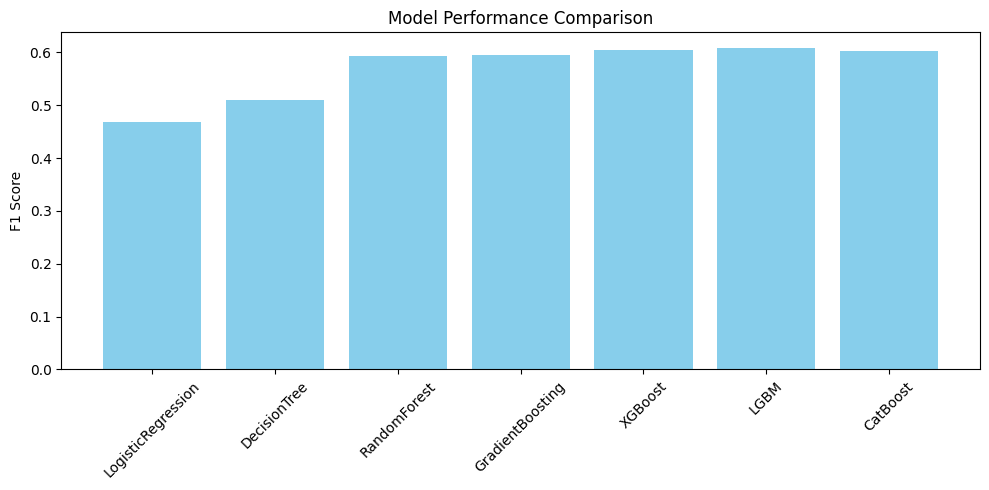

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()


In [25]:
# Final Comparison Summary
print("\n--- Final F1 Score Comparison ---")
for model_name, f1_val in results.items():
    print(f"{model_name}: F1 = {f1_val:.4f}")

print(f"RandomForest (after HPT): F1 = {grid_rf.best_score_:.4f}")
print(f"XGBoost (after HPT):     F1 = {grid_xgb.best_score_:.4f}")
print(f"LightGBM (after HPT):    F1 = {grid_lgbm.best_score_:.4f}")


--- Final F1 Score Comparison ---
LogisticRegression: F1 = 0.4687
DecisionTree: F1 = 0.5103
RandomForest: F1 = 0.5927
GradientBoosting: F1 = 0.5949
XGBoost: F1 = 0.6054
LGBM: F1 = 0.6076
CatBoost: F1 = 0.6029
RandomForest (after HPT): F1 = 0.5986
XGBoost (after HPT):     F1 = 0.6223
LightGBM (after HPT):    F1 = 0.6244


In [26]:
final_model = grid_lgbm.best_estimator_# train on full data


In [27]:
# Predict
test_preds = final_model.predict(test)

# Prepare submission file
submission = pd.DataFrame({
    "id": range(test.shape[0]),
    'exit_status': test_preds
})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")


Submission file created!


In [28]:
ss=pd.read_csv("submission.csv")
ss.head()

,id,exit_status
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
